
Ultimate Stock Prediction Engine
Analyzing: AAPL


[*********************100%***********************]  1 of 1 completed



══════════════════════════════════════════════════════════════════════
FINAL VERDICT
══════════════════════════════════════════════════════════════════════
Stock        : AAPL
Price        : $273.40
5D Forecast  : DOWN
Confidence   : 21.0%
ARIMA (1d)   : $273.39
SIGNAL       : STRONG SELL
══════════════════════════════════════════════════════════════════════


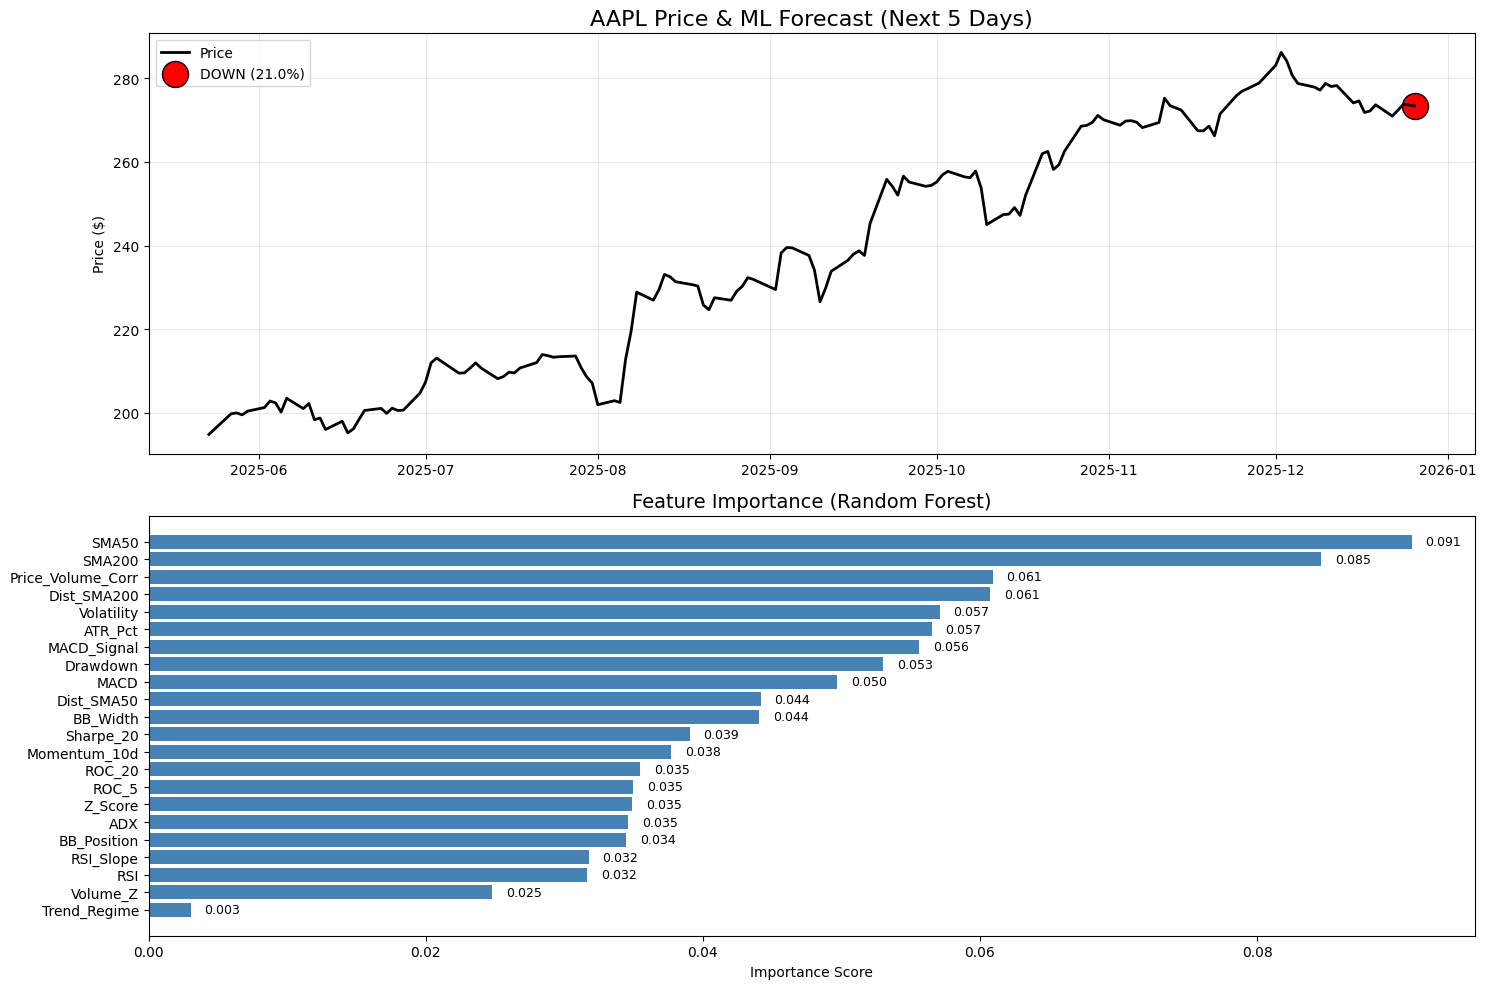

In [1]:
# =======================================================
# ULTIMATE STOCK PREDICTION DASHBOARD (FINAL, BUG-FIXED)
# =======================================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# ========================= CONFIG =========================
ticker = "AAPL"
forecast_days = 5
# =========================================================

print(f"\nUltimate Stock Prediction Engine")
print(f"Analyzing: {ticker}")
print("=" * 70)

# ------------------- 1. Download Data -------------------
df = yf.download(ticker, period="3y", interval="1d")
if df.empty:
    raise ValueError("No data downloaded")

df = df.dropna()

# 🔒 FORCE SERIES (critical fix)
close = df["Close"].squeeze()
high = df["High"].squeeze()
low = df["Low"].squeeze()
volume = df["Volume"].squeeze()

latest_price = float(close.iloc[-1])

# ------------------- 2. Feature Engineering -------------------
data = df.copy()

# ===== Target (future, NEVER a feature) =====
data["Return_5d"] = close.pct_change(forecast_days).shift(-forecast_days)
data["Target"] = (data["Return_5d"] > 0).astype(int)

# ===== Trend =====
data["SMA50"] = close.rolling(50).mean()
data["SMA200"] = close.rolling(200).mean()
data["Dist_SMA50"] = (close - data["SMA50"]) / close
data["Dist_SMA200"] = (close - data["SMA200"]) / close
data["Trend_Regime"] = (data["SMA50"] > data["SMA200"]).astype(int)

# ===== Momentum =====
data["Momentum_10d"] = close.pct_change(10)
data["ROC_5"] = close.pct_change(5)
data["ROC_20"] = close.pct_change(20)

ema12 = close.ewm(span=12).mean()
ema26 = close.ewm(span=26).mean()
data["MACD"] = ema12 - ema26
data["MACD_Signal"] = data["MACD"].ewm(span=9).mean()

delta = close.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = -delta.where(delta < 0, 0).rolling(14).mean()
rs = gain / loss
data["RSI"] = 100 - (100 / (1 + rs))
data["RSI_Slope"] = data["RSI"].diff(5)

# ===== Volatility & Risk =====
data["Volatility"] = close.pct_change().rolling(20).std() * np.sqrt(252)

tr = pd.concat([
    high - low,
    (high - close.shift()).abs(),
    (low - close.shift()).abs()
], axis=1).max(axis=1)

atr = tr.rolling(14).mean()
data["ATR_Pct"] = atr / close

plus_dm = high.diff()
minus_dm = low.diff().abs()
plus_di = 100 * (plus_dm.rolling(14).mean() / atr)
minus_di = 100 * (minus_dm.rolling(14).mean() / atr)
data["ADX"] = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100

# ===== Position & Behavior =====
mid = close.rolling(20).mean()
std = close.rolling(20).std()
data["BB_Position"] = (close - mid) / std
data["BB_Width"] = (2 * std) / close

data["Z_Score"] = (close - close.rolling(60).mean()) / close.rolling(60).std()
data["Price_Volume_Corr"] = close.rolling(60).corr(volume)

vol_mean = volume.rolling(20).mean()
data["Volume_Z"] = (volume - vol_mean) / volume.rolling(20).std()

returns = close.pct_change()
data["Sharpe_20"] = returns.rolling(20).mean() / returns.rolling(20).std()

rolling_max = close.cummax()
data["Drawdown"] = (close - rolling_max) / rolling_max

# ------------------- 3. Final Feature Set -------------------
features = [
    "SMA50","SMA200","Dist_SMA50","Dist_SMA200",
    "Trend_Regime","ADX",
    "Momentum_10d","ROC_5","ROC_20",
    "MACD","MACD_Signal","RSI","RSI_Slope",
    "Volatility","ATR_Pct","BB_Width","Drawdown",
    "BB_Position","Z_Score","Price_Volume_Corr",
    "Volume_Z","Sharpe_20"
]

X = data[features]
y = data["Target"]

X_clean = X.dropna()
y_clean = y.loc[X_clean.index]

# ------------------- 4. Train ML Model -------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

model = RandomForestClassifier(
    n_estimators=800,
    min_samples_leaf=5,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X_scaled, y_clean)

# ------------------- 5. Latest Prediction -------------------
latest_X = X.tail(1).fillna(X_clean.median())
latest_scaled = scaler.transform(latest_X)

proba = model.predict_proba(latest_scaled)[0][1]
prediction = "UP" if proba > 0.5 else "DOWN"

# ------------------- 6. ARIMA Reference -------------------
try:
    arima = ARIMA(close, order=(5,1,0)).fit()
    arima_forecast = float(arima.forecast(1))
except:
    arima_forecast = latest_price

# ------------------- 7. Verdict -------------------
print("\n" + "═" * 70)
print("FINAL VERDICT")
print("═" * 70)
print(f"Stock        : {ticker}")
print(f"Price        : ${latest_price:.2f}")
print(f"5D Forecast  : {prediction}")
print(f"Confidence   : {proba:.1%}")
print(f"ARIMA (1d)   : ${arima_forecast:.2f}")

if proba >= 0.70:
    signal = "STRONG BUY"
elif proba >= 0.58:
    signal = "BUY"
elif proba <= 0.30:
    signal = "STRONG SELL"
elif proba <= 0.42:
    signal = "SELL"
else:
    signal = "HOLD / WAIT"

print(f"SIGNAL       : {signal}")
print("═" * 70)

# ------------------- 8. FULL DASHBOARD PLOT -------------------
plt.figure(figsize=(15, 10))

# Price chart
plt.subplot(2, 1, 1)
plt.plot(close[-150:], label="Price", linewidth=2, color="black")
plt.scatter(
    close.index[-1],
    latest_price,
    s=350,
    color="green" if prediction == "UP" else "red",
    edgecolors="black",
    label=f"{prediction} ({proba:.1%})"
)
plt.title(f"{ticker} Price & ML Forecast (Next {forecast_days} Days)", fontsize=16)
plt.ylabel("Price ($)")
plt.legend()
plt.grid(alpha=0.3)

# Feature importance
plt.subplot(2, 1, 2)
importances = model.feature_importances_
imp_df = pd.Series(importances, index=features).sort_values()

plt.barh(imp_df.index, imp_df.values, color="steelblue")
plt.title("Feature Importance (Random Forest)", fontsize=14)
plt.xlabel("Importance Score")

for i, v in enumerate(imp_df.values):
    plt.text(v + 0.001, i, f"{v:.3f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()
